# Multiple regression, with intercept

{ucb-page}`Multiple_Regression`

In [1]:
import numpy as np
# Make random number generator.
rng = np.random.default_rng()
import pandas as pd
# Safe setting for Pandas.  Needs Pandas version >= 1.5.
pd.set_option('mode.copy_on_write', True)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.set_printoptions(suppress=True)

In [2]:

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

def correlation(t, x, y):
    return np.mean(standard_units(t[x]) * standard_units(t[y]))

Now that we have explored ways to use multiple attributes to predict a
categorical variable, let us return to predicting a quantitative variable.
Predicting a numerical quantity is called regression, and a commonly used
method to use multiple attributes for regression is called *multiple linear
regression*.


## Home Prices


The following dataset of house prices and attributes was collected over several
years for the city of Ames, Iowa. A [description of the dataset appears
online](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We will focus
only a subset of the columns. We will try to predict the sale price column from
the other columns.

In [3]:
all_sales = pd.read_csv('house.csv')
sales = all_sales.loc[np.logical_and(all_sales['Bldg Type'] == '1Fam',
                      all_sales['Sale Condition'] == 'Normal'),
    ['SalePrice', '1st Flr SF', '2nd Flr SF',
     'Total Bsmt SF', 'Garage Area',
     'Wood Deck SF', 'Open Porch SF', 'Lot Area',
     'Year Built', 'Yr Sold']]
sales.sort_values('SalePrice')

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
2843,35000,498,0,498.0,216.0,0,0,8088,1922,2006
1901,39300,334,0,0.0,0.0,0,0,5000,1946,2007
1555,40000,649,668,649.0,250.0,0,54,8500,1920,2008
708,45000,612,0,0.0,308.0,0,0,5925,1940,2009
1220,52000,729,0,270.0,0.0,0,0,4130,1935,2008
...,...,...,...,...,...,...,...,...,...,...
2450,584500,1933,1567,1733.0,959.0,870,86,17242,1993,2006
432,610000,2674,0,2630.0,762.0,360,50,13693,2007,2009
1063,615000,2470,0,2535.0,789.0,154,65,12720,2003,2008
2445,625000,1831,1796,1930.0,807.0,361,76,35760,1995,2006


A histogram of sale prices shows a large amount of variability and a
distribution that is clearly not normal. A long tail to the right contains a
few houses that had very high prices. The short left tail does not contain any
houses that sold for less than \$35,000.

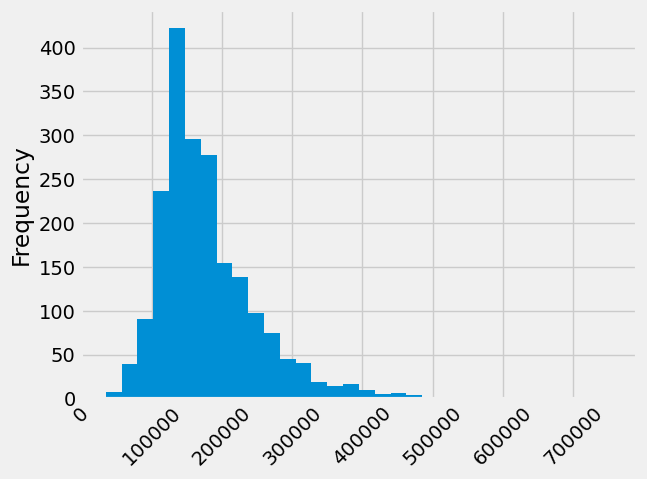

In [4]:
sales['SalePrice'].plot.hist(bins=32)
plt.xticks(rotation=45);

## Correlation

No single attribute is sufficient to predict the sale price. For example, the area of first floor, measured in square feet, correlates with sale price but only explains some of its variability.

<AxesSubplot: xlabel='1st Flr SF', ylabel='SalePrice'>

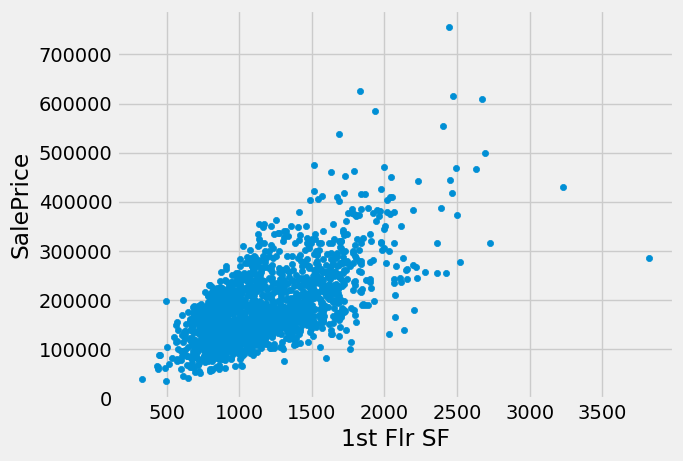

In [5]:
sales.plot.scatter('1st Flr SF', 'SalePrice')

In [6]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In fact, none of the individual attributes have a correlation with sale price that is above 0.7 (except for the sale price itself).

In [7]:
for col_name in sales.columns:
    r = correlation(sales, col_name, 'SalePrice')
    print(f'Correlation of {col_name} and SalePrice:\t{r:0.3f}', )

Correlation of SalePrice and SalePrice:	1.000
Correlation of 1st Flr SF and SalePrice:	0.642
Correlation of 2nd Flr SF and SalePrice:	0.358
Correlation of Total Bsmt SF and SalePrice:	0.653
Correlation of Garage Area and SalePrice:	0.639
Correlation of Wood Deck SF and SalePrice:	0.353
Correlation of Open Porch SF and SalePrice:	0.337
Correlation of Lot Area and SalePrice:	0.291
Correlation of Year Built and SalePrice:	0.565
Correlation of Yr Sold and SalePrice:	0.026


However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone.

In [8]:
with_both = sales.copy()
with_both['Both Floors'] = sales['1st Flr SF'] + sales['2nd Flr SF']
correlation(with_both, 'SalePrice', 'Both Floors')

0.7821920556134877

This high correlation indicates that we should try to use more than one attribute to predict the sale price. In a dataset with multiple observed attributes and a single numerical value to be predicted (the sale price in this case), multiple linear regression can be an effective technique.


## Multiple Linear Regression

In multiple linear regression, a numerical output is predicted from numerical input attributes by multiplying each attribute value by a different slope, then summing the results. In this example, the slope for the `1st Flr SF` would represent the dollars per square foot of area on the first floor of the house that should be used in our prediction. 

Before we begin prediction, we split our data randomly into a training and test set of equal size.

In [9]:
N = len(sales)
half_N = int(N / 2)
# Shuffle data frame by taking random sample with same number of rows.
shuffled_sales = sales.sample(n=N, replace=False)
train = shuffled_sales.iloc[:half_N]
test = shuffled_sales.iloc[half_N:]
print(len(train), 'training and', len(test), 'test instances.')

1001 training and 1001 test instances.


The slopes in multiple regression is an array that has one slope value for each attribute in an example. Predicting the sale price involves multiplying each attribute by the slope and summing the result.

In [10]:
def predict(c_slopes, row):
    c = c_slopes[0]
    slopes = c_slopes[1:]
    return c + np.sum(slopes * np.array(row))

example_row = test.drop(columns='SalePrice').iloc[0]
print('Predicting sale price for:', example_row)
example_c_slopes = np.concatenate([
    [1], # Intercept
    rng.normal(10, 1, size=len(example_row)) # Slopes
])
               
print('Using slopes:', example_c_slopes)
print('Result:', predict(example_c_slopes, example_row))

Predicting sale price for: 1st Flr SF        1236.0
2nd Flr SF        1104.0
Total Bsmt SF     1236.0
Garage Area        787.0
Wood Deck SF       192.0
Open Porch SF      180.0
Lot Area         14311.0
Year Built        1996.0
Yr Sold           2008.0
Name: 1032, dtype: float64
Using slopes: [ 1.         11.11143669 10.94942681  9.38235003 10.51868913 10.18330367
  9.07925278  9.86711122  9.06086713 10.14883674]
Result: 228959.7393273126


The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the `example_slopes` above were chosen at random, we should not expect them to provide accurate predictions at all.

In [11]:
print('Actual sale price:', test['SalePrice'].iloc[0])
print('Predicted sale price using random slopes:',
      predict(example_c_slopes, example_row))

Actual sale price: 306000
Predicted sale price using random slopes: 228959.7393273126


## Least Squares Regression

The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices.

In [12]:
train_prices = train['SalePrice']
train_attributes = train.drop(columns='SalePrice')

def rmse(c_slopes, attributes, y_values):
    errors = []
    for i in np.arange(len(y_values)):
        predicted = predict(c_slopes, attributes.iloc[i])
        actual = y_values.iloc[i]
        errors.append((actual - predicted) ** 2)
    return np.sqrt(np.mean(errors))

def rmse_train(c_slopes):
    return rmse(c_slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_c_slopes))

RMSE of all training examples using random slopes: 90246.38102463174


Actually, the `rmse` routine above is correct, but it is slow, because we are
looping through each rows in the data frame.  Here's a version that does the
same calculation, but more efficiently, without a loop, using Numpy arrays.
Don't worry about the details, unless you are interested.

In [13]:
def rmse_fast(c_slopes, attributes, y_values):
    # Make an n by s array of slopes by copying the s slopes array n times.
    c = c_slopes[0]
    slopes = c_slopes[1:]
    slopes_array = np.tile(slopes, [len(y_values), 1])
    # Multiply the n by s array by the corresponding attributes.
    predicted = c + np.sum(slopes_array * attributes, axis=1)
    errors = y_values - predicted
    return np.sqrt(np.mean(errors ** 2))

def rmse_train_fast(c_slopes):
    return rmse_fast(c_slopes, train_attributes, train_prices)

print('Fast RMSE of all training examples using random slopes:',
      rmse_train_fast(example_c_slopes))

Fast RMSE of all training examples using random slopes: 90246.38102463174


Finally, we use the `minimize` function to find the slopes with the lowest
RMSE. Computation of the best slopes may take several minutes.

In [14]:
from scipy.optimize import minimize

We specify that we want to use the
[Powell](https://en.wikipedia.org/wiki/Powell%27s_method) method to search for
the minimum.

In [15]:
# Use minimize to calculate smallest RMSE slopes.
multi_res = minimize(rmse_train_fast, example_c_slopes, method='powell')
multi_res

   direc: array([[ -856.16748445,   -20.76778795,    -2.82926601,    14.47352906,
           29.26233766,     5.62715656,   -55.95266334,     0.0295505 ,
          -10.18358961,     9.33189339],
       [    0.        ,     1.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [-2824.50200238,    37.12555966,   -19.6265934 ,    19.45445135,
            0.97227996,    27.55926847,     6.43300135,    -1.40801936,
            6.34292699,   -26.80649614],
       [    0.        ,     0.        ,     0.        ,     1.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            1.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.   

In [16]:
best_slopes = multi_res.x
print('The best slopes for the training set:')
print('RMSE of all training examples using the best slopes:',
      rmse_train_fast(best_slopes))
pd.DataFrame(data=[best_slopes], 
             columns=['Intercept'] + list(train_attributes.columns)
            )

The best slopes for the training set:
RMSE of all training examples using the best slopes: 32923.91493481577


,Intercept,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
0,-12687.954313,73.708169,79.199429,57.61026,76.154935,50.740045,5.855236,0.467005,22.875964,-34.715896


## Interpreting Multiple Regression

Let's interpret these results. The best slopes give us a method for estimating
the price of a house from its attributes. A square foot of area on the first
floor is worth about 80 USD (the first slope), while one on the second floor is
worth about 75 USD (the second slope). The final negative value describes the
market: prices in later years were lower on average.

The RMSE of around 30,000 USD means that our best linear prediction of the sale
price based on all of the attributes is off by around 30,000 USD on the
training set, on average.  We find a similar error when predicting prices on
the test set, which indicates that our prediction method will generalize to
other samples from the same population.

In [17]:
test_prices = test['SalePrice']
test_attributes = test.drop(columns='SalePrice')

def rmse_test(slopes):
    return rmse_fast(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 33845.44299021401


If the predictions were perfect, then a scatter plot of the predicted and
actual values would be a straight line with slope 1. We see that most dots fall
near that line, but there is some error in the predictions.

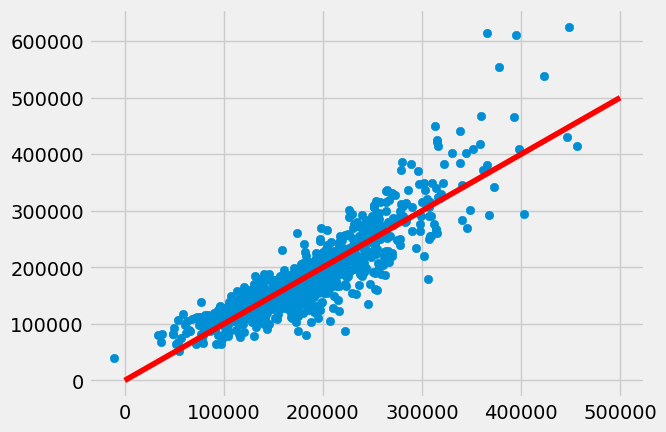

In [18]:
def fit(row):
    return best_slopes[0] + sum(best_slopes[1:] * np.array(row))

fitted = test_attributes.apply(fit, axis=1)
plt.scatter(fitted, test_prices)
# Plot x=y line.
plt.plot([0, 5e5], [0, 5e5], color='red');

A residual plot for multiple regression typically compares the errors
(residuals) to the actual values of the predicted variable. We see in the
residual plot below that we have systematically underestimated the value of
expensive houses, shown by the many positive residual values on the right side
of the graph.

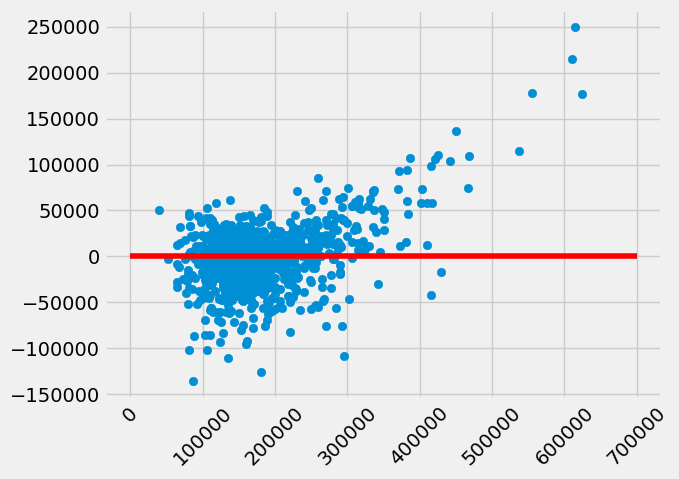

In [19]:
plt.scatter(test_prices, test_prices - fitted)
plt.plot([0, 7e5], [0, 0], color='red')
plt.xticks(rotation=45);

As with simple linear regression, interpreting the result of a predictor is at least as important as making predictions. There are many lessons about interpreting multiple regression that are not included in this textbook. A natural next step after completing this text would be to study linear modeling and regression in further depth.


## Nearest Neighbors for Regression

Another approach to predicting the sale price of a house is to use the price of similar houses. This *nearest neighbor* approach is very similar to our classifier. To speed up computation, we will only use the attributes that had the highest correlation with the sale price in our original analysis.

In [20]:
train_nn = train.iloc[:, [0, 1, 2, 3, 4, 8]]
test_nn = test.iloc[:, [0, 1, 2, 3, 4, 8]]
train_nn.head(3)

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
2276,281213,1133,1349,1094.0,642.0,2005
1093,226750,1008,884,982.0,431.0,2000
2306,157500,1024,0,1008.0,313.0,1956


The computation of closest neighbors is identical to a nearest-neighbor classifier. In this case, we will exclude the `'SalePrice'` rather than the `'Class'` column from the distance computation. The five nearest neighbors of the first test row are shown below.

In [21]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    attributes = training.drop(columns=output)

    def distance_from_example(row):
        return row_distance(row, example)

    out = training.copy()
    out['Distance'] = attributes.apply(distance_from_example, axis=1)
    return out

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    dist_df = distances(training, example, output)
    return dist_df.sort_values('Distance').head(k)

example_nn_row = test_nn.drop(columns='SalePrice').iloc[0]
closest(train_nn, example_nn_row, 5, 'SalePrice')

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
91,362500,1251,1098,1231.0,762.0,1993,30.331502
1062,316000,1170,1162,1148.0,756.0,2004,128.409501
490,245000,1223,1089,1177.0,658.0,1999,143.265488
2897,250000,1298,1216,1216.0,693.0,1990,160.187390
63,290000,1164,1106,1152.0,671.0,1999,160.340263


One simple method for predicting the price is to average the prices of the nearest neighbors.

In [22]:
def predict_nn(example):
    """Return average of the price across the 5 nearest neighbors.
    """
    five_nearest = closest(train_nn, example, 5, 'SalePrice')
    return np.mean(five_nearest['SalePrice'])

predict_nn(example_nn_row)

292700.0

Finally, we can inspect whether our prediction is close to the true sale price
for our one test example. Looks reasonable!

In [23]:
print('Actual sale price:', test_nn['SalePrice'].iloc[0])
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 306000
Predicted sale price using nearest neighbors: 292700.0


## Evaluation

To evaluate the performance of this approach for the whole test set, we apply
`predict_nn` to each test example, then compute the root mean squared error of
the predictions. Computation of the predictions may take several minutes.

In [24]:
attributes = test_nn.drop(columns='SalePrice')
nn_test_predictions = attributes.apply(predict_nn, axis=1)
rmse_nn = np.sqrt(np.mean((test_prices - nn_test_predictions) ** 2))

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  33845.44299021401
Test set RMSE for nearest neighbor regression: 33297.74045622841


For these data, the errors of the two techniques are quite similar! For
different data sets, one technique might outperform another. By computing the
RMSE of both techniques on the same data, we can compare methods fairly. One
note of caution: the difference in performance might not be due to the
technique at all; it might be due to the random variation due to sampling the
training and test sets in the first place.

Finally, we can draw a residual plot for these predictions. We still
underestimate the prices of the most expensive houses, but the bias does not
appear to be as systematic. However, fewer residuals are very close to zero,
indicating that fewer prices were predicted with very high accuracy. 

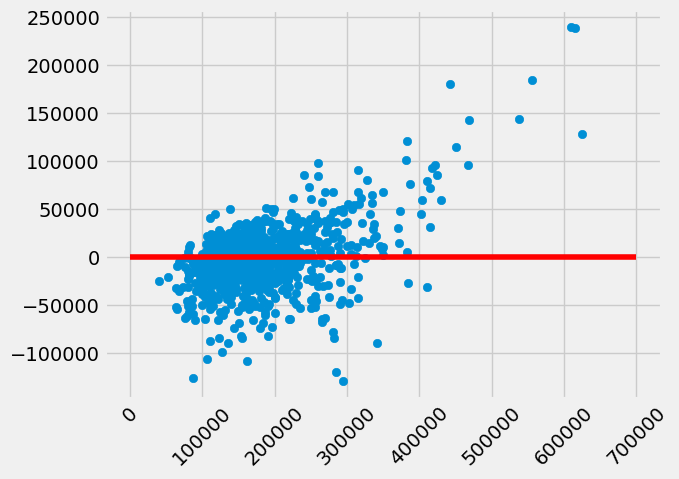

In [25]:
plt.scatter(test_prices, test_prices - nn_test_predictions)
plt.plot([0, 7e5], [0, 0], color='red')
plt.xticks(rotation=45);

{ucb-page}`Multiple_Regression`